In [1]:
import tensorflow
print(tensorflow.__version__)
tensorflow.test.gpu_device_name()

1.8.0


'/device:GPU:0'

## --------------

In [2]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import tensorflow as tf

import matplotlib.pyplot as plt

import os
import sys
import copy

import numpy as np
from datetime import datetime
from random import shuffle

from PIL import Image, ImageDraw

Using TensorFlow backend.


In [3]:
IMAGE_H, IMAGE_W = 416, 416
BOX = 5
GRID_H, GRID_W = 13, 13
TRUE_BOX_BUFFER  = 50
BATCH_SIZE       = 32

# граница вероятности для предсказаний
OBJ_THRESHOLD    = 0.3#0.5

train_coef = 0.7
valid_coef = 0.1

In [4]:
def get_squared_image(image, size):
    copy_img = image.copy()
    copy_img.thumbnail((size, size), Image.ANTIALIAS)
    x__, y__ = copy_img.size
    new_im = Image.new('RGB', (size, size), (0, 0, 0))
    new_im.paste(copy_img, (int((size - x__) / 2), int((size - y__) / 2)))
    return new_im

## check data

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave10_10_2012_12_07_05_1.jpg


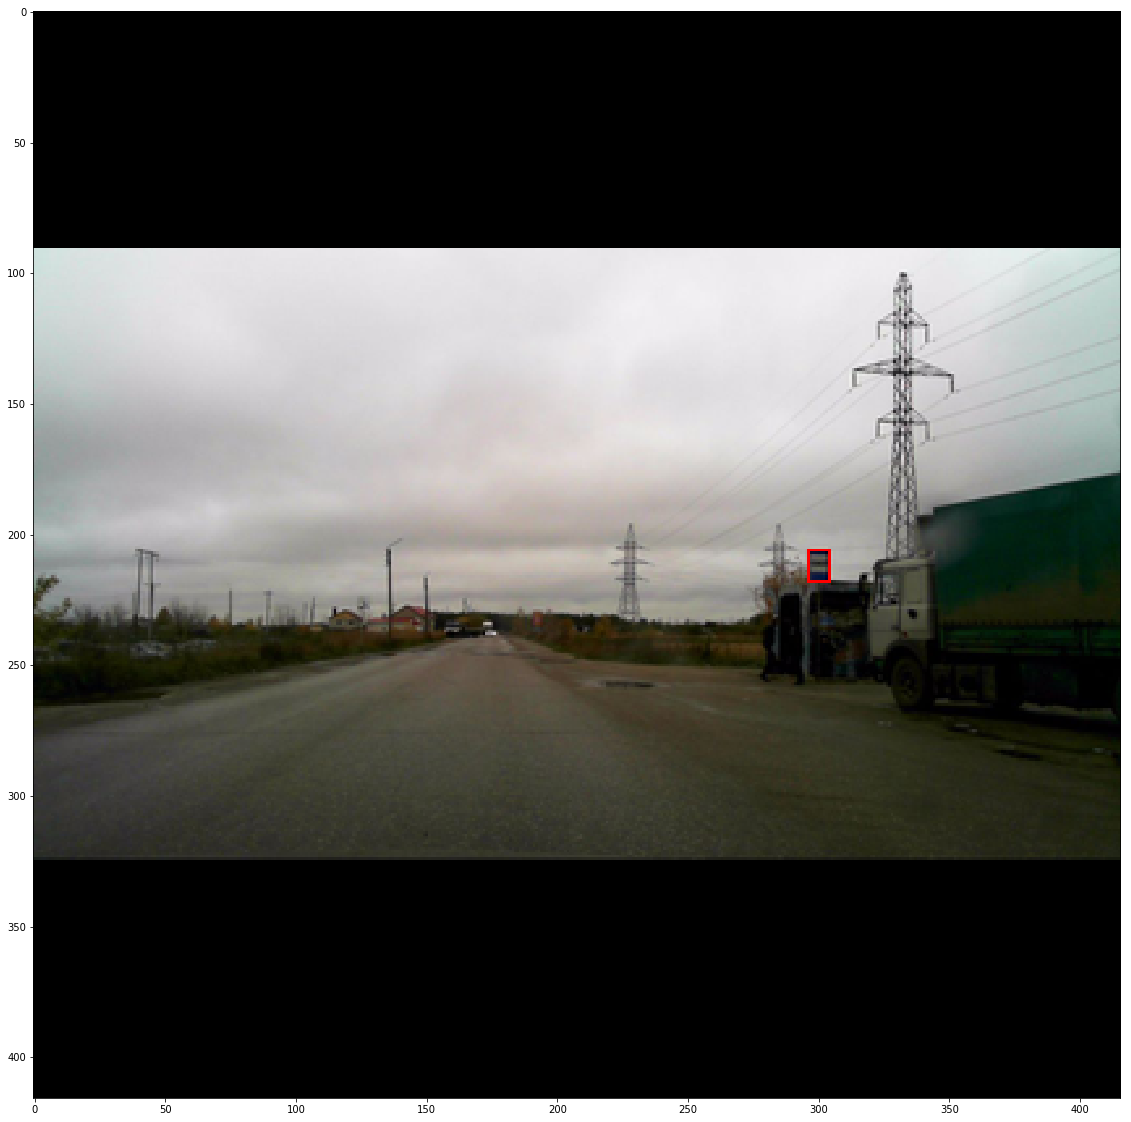

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave10_10_2012_10_28_24_1.jpg


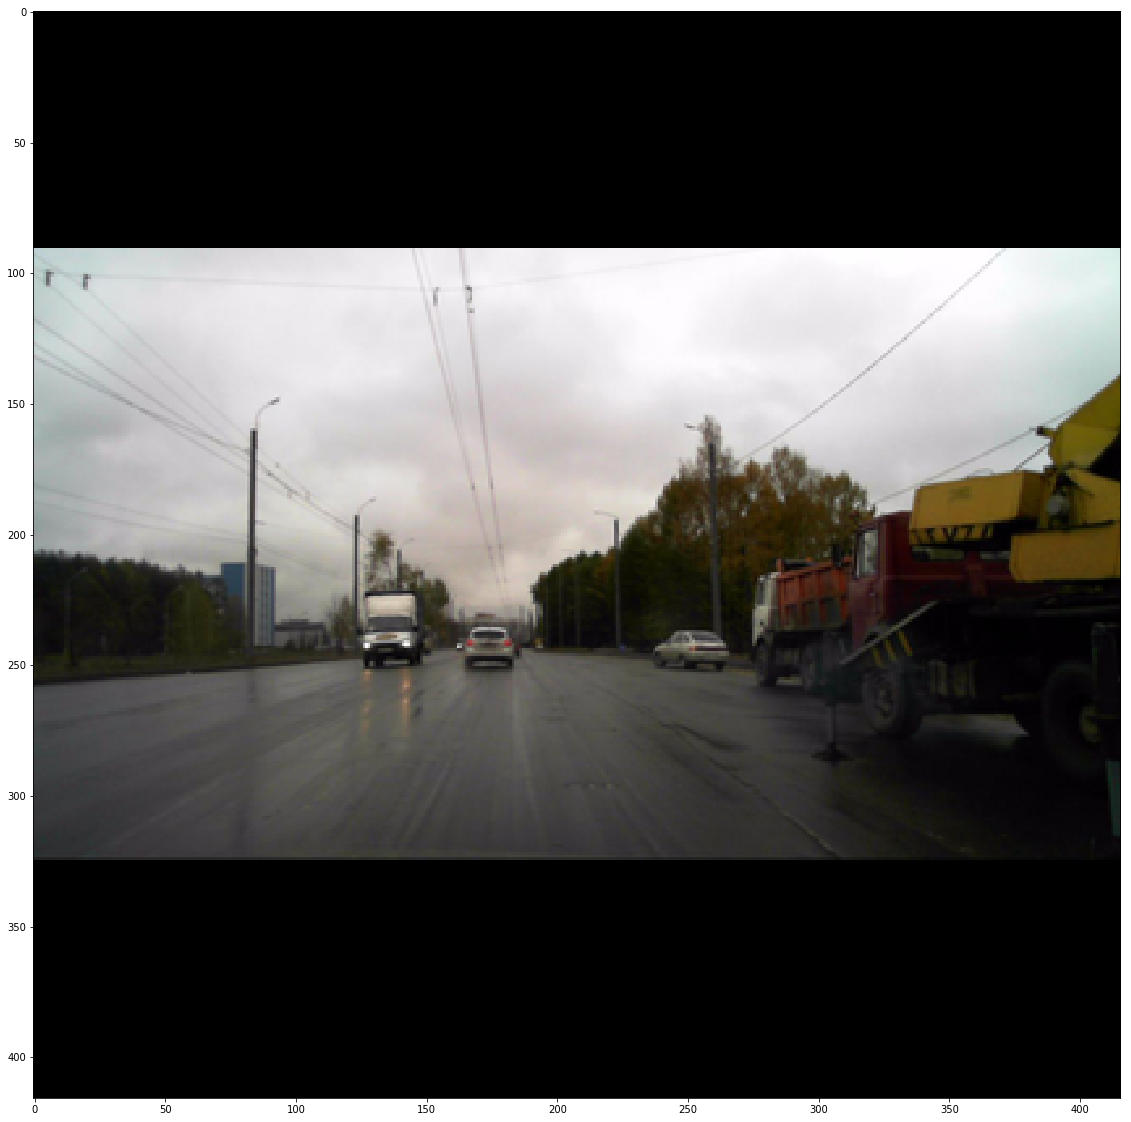

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave16_10_2012_09_41_00_0.jpg


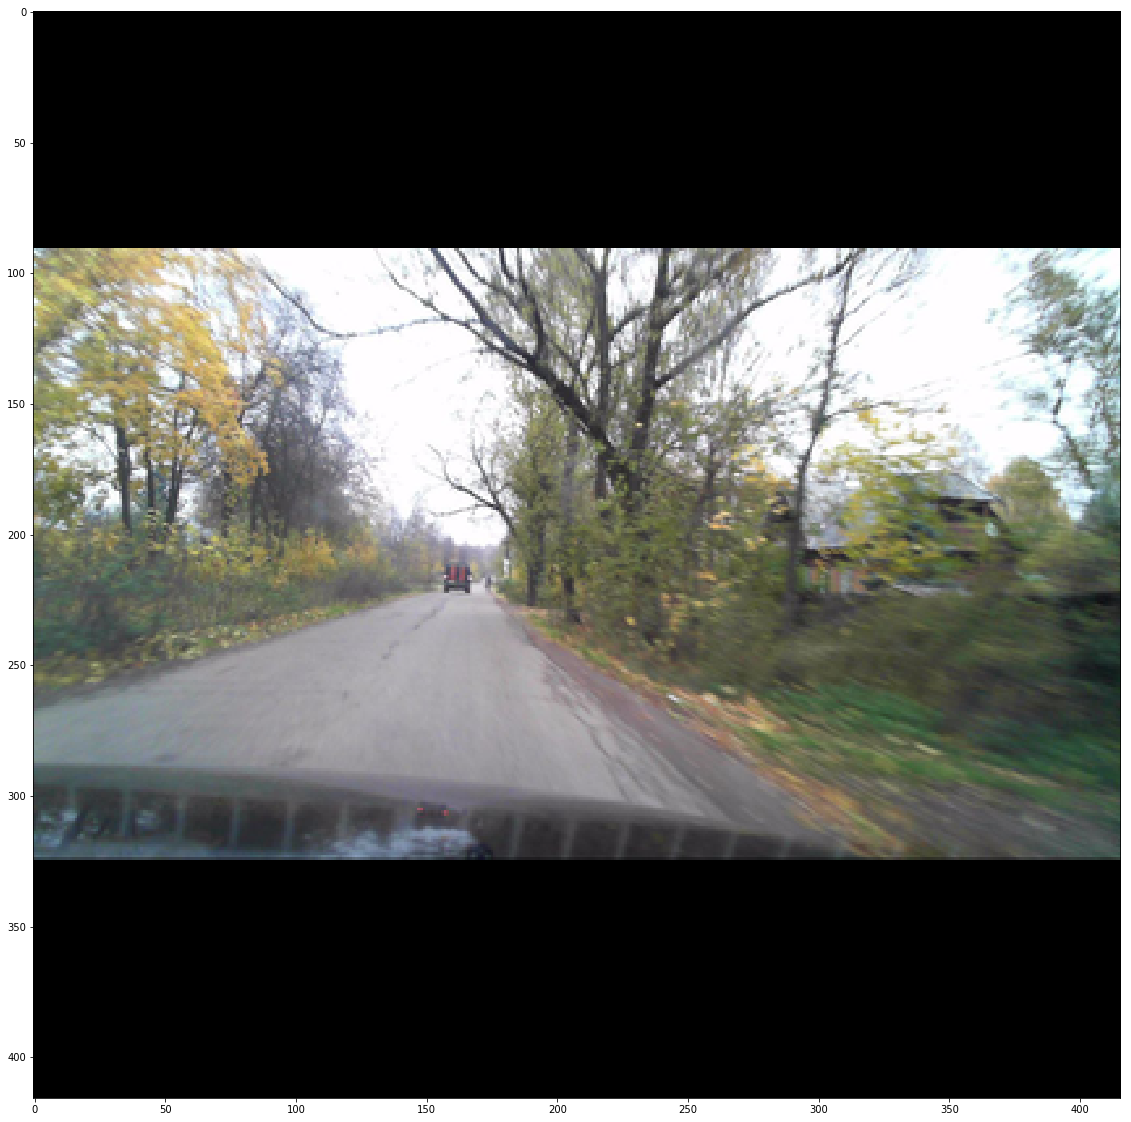

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave09_10_2012_12_23_48_1.jpg


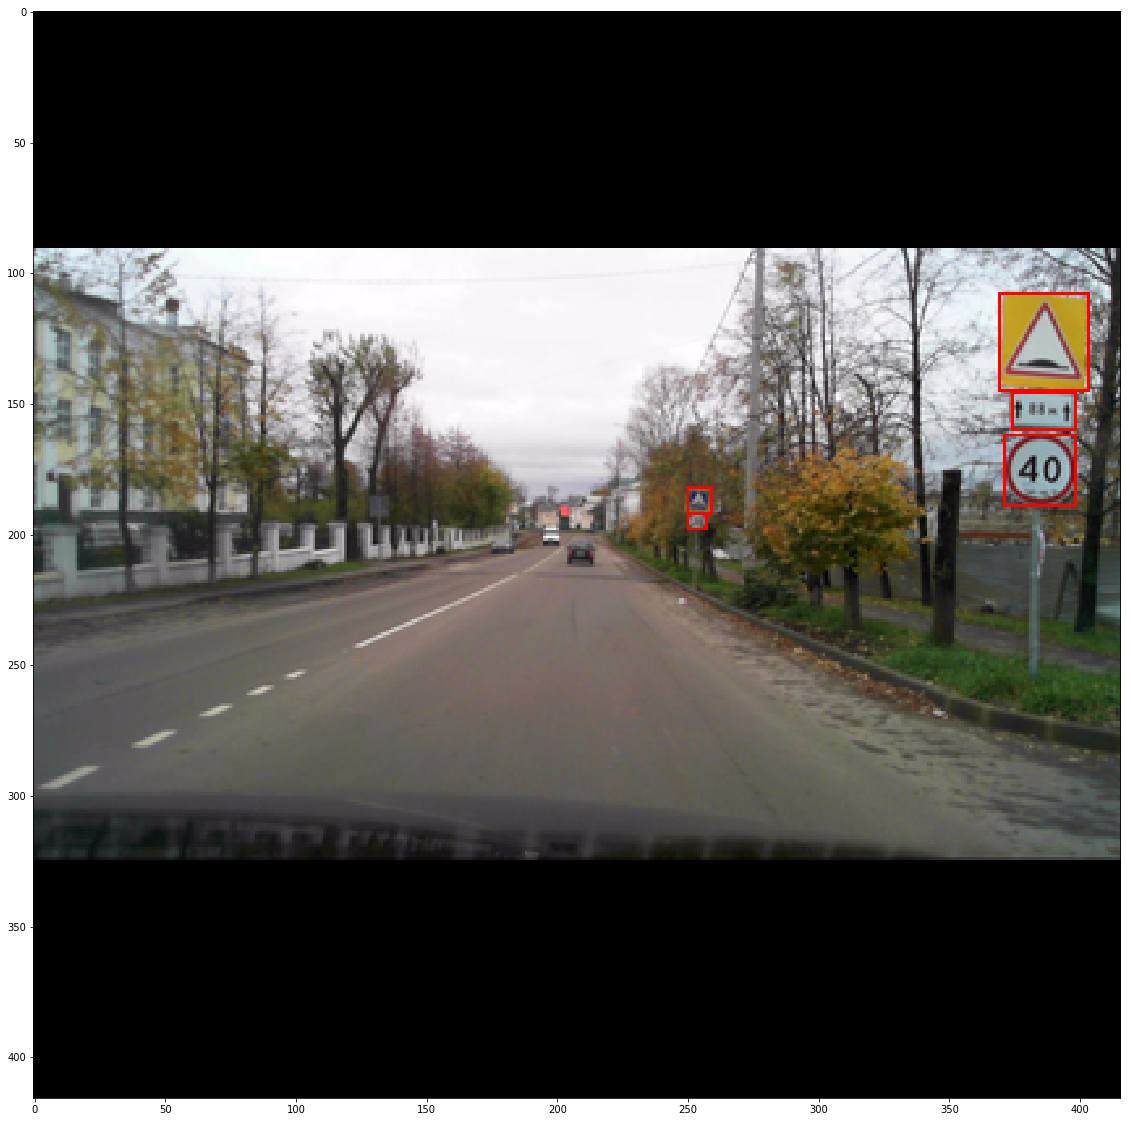

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave16_10_2012_08_22_43_1.jpg


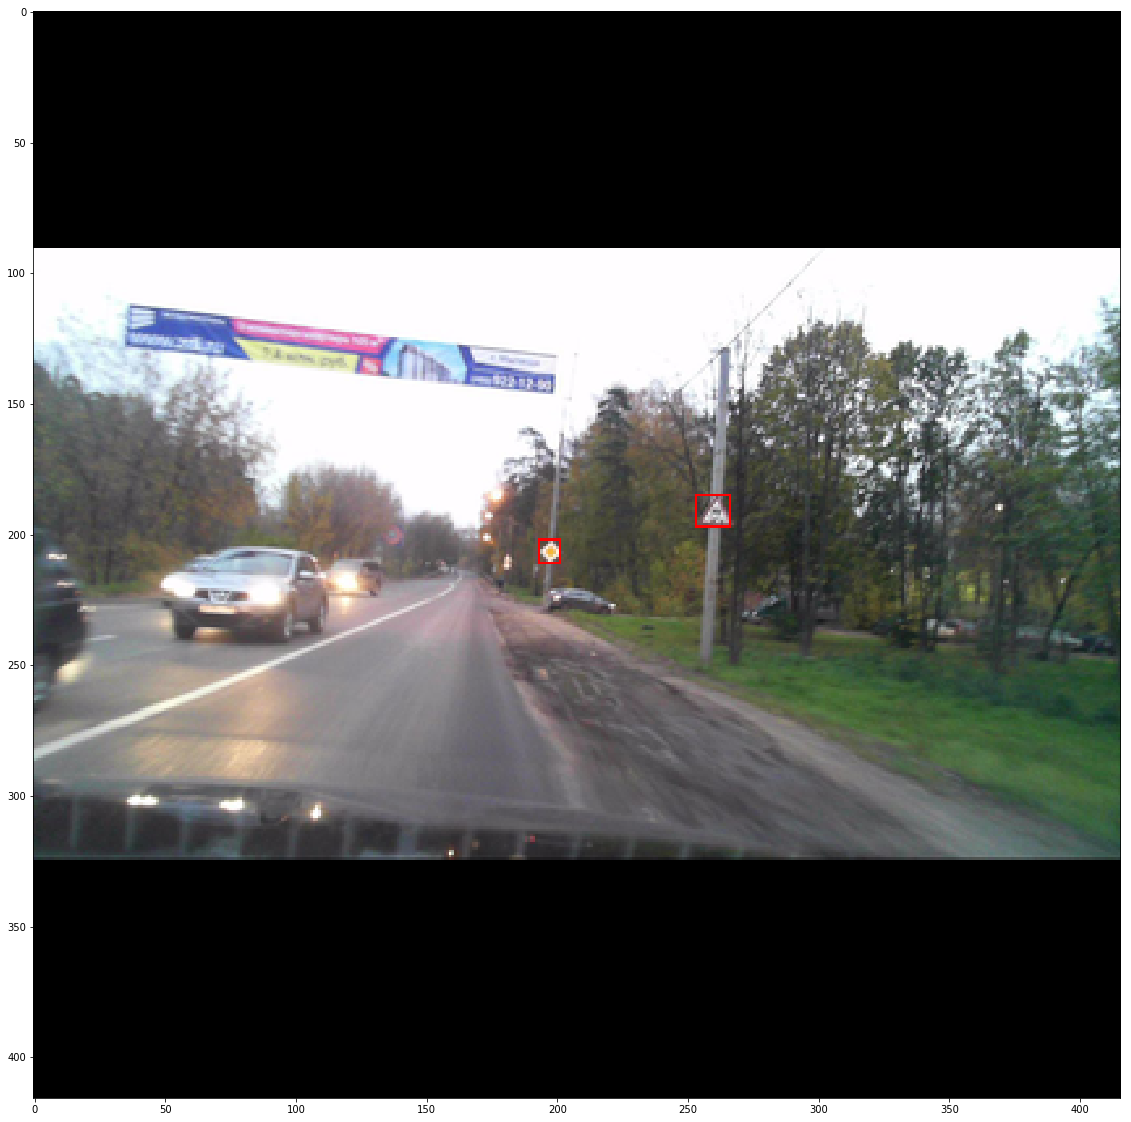

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave21_01_2013_13_51_43_2.jpg


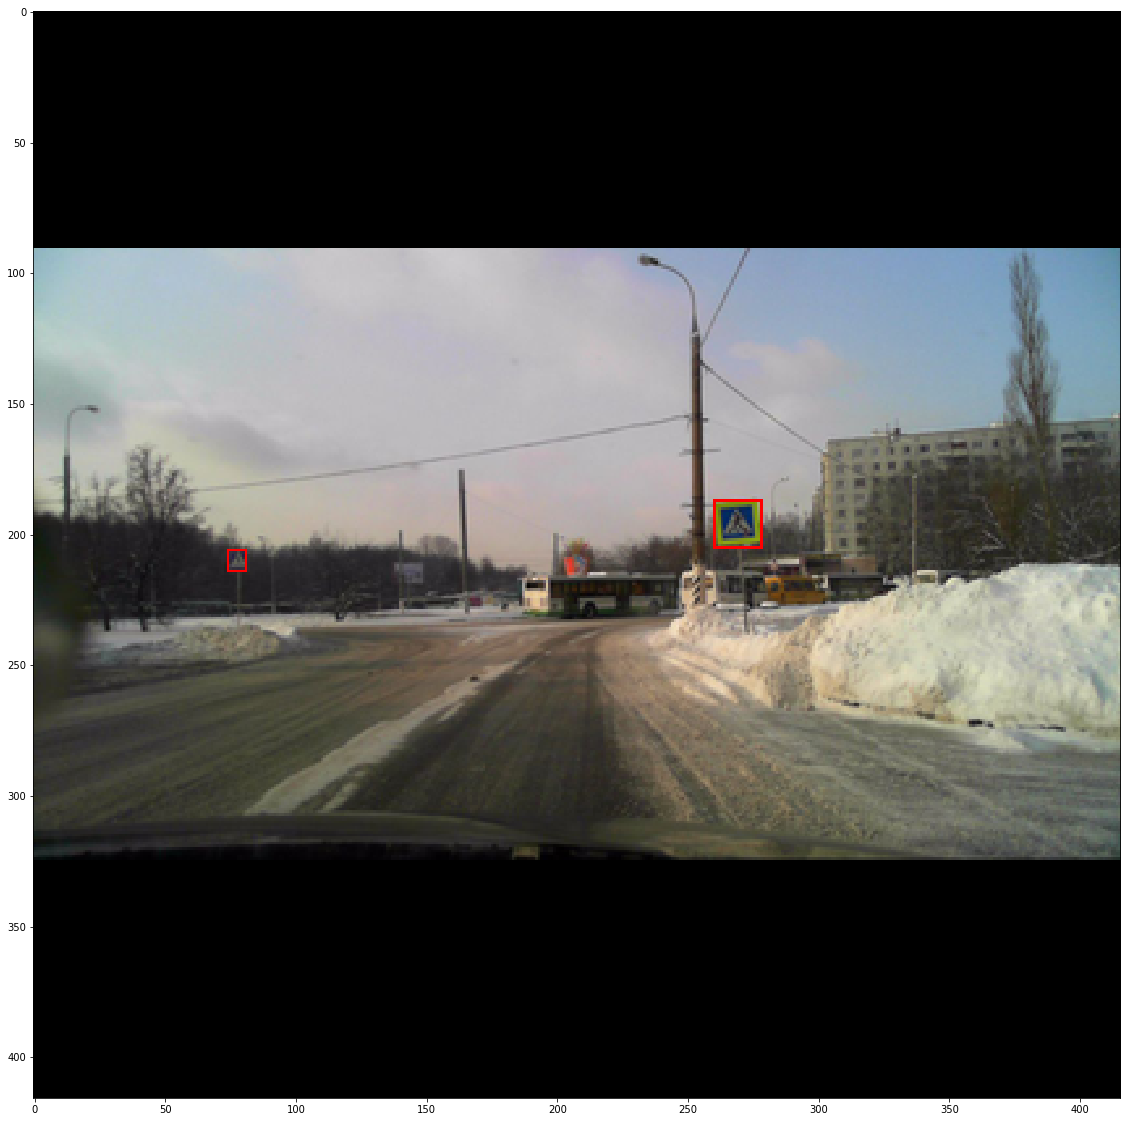

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave16_04_2013_11_52_56_0.jpg


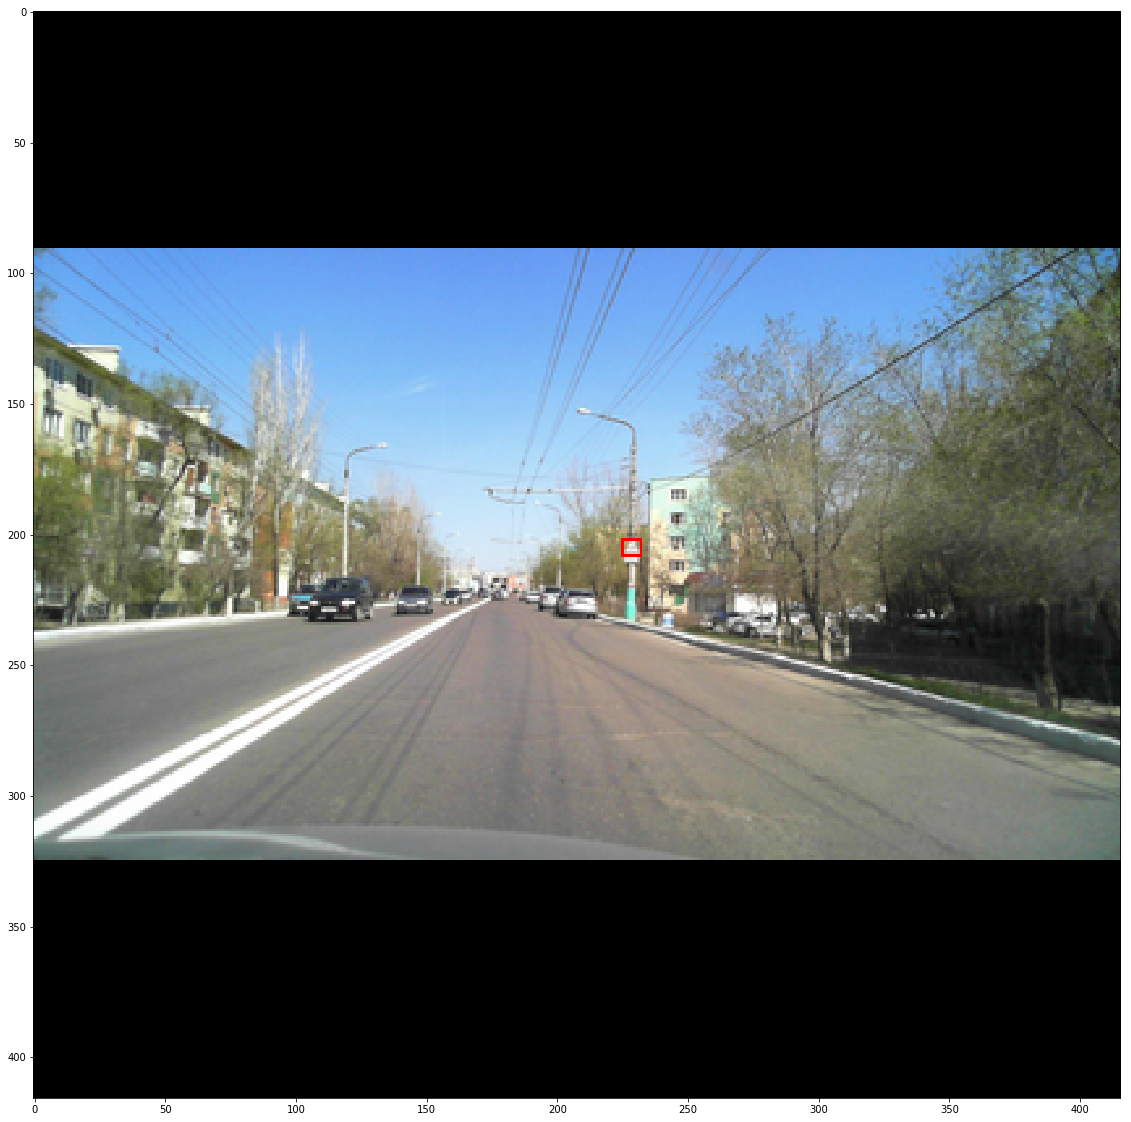

/jet/prs/russian_signs/rtsd/rtsd-frames/autosave09_10_2012_14_07_26_2.jpg


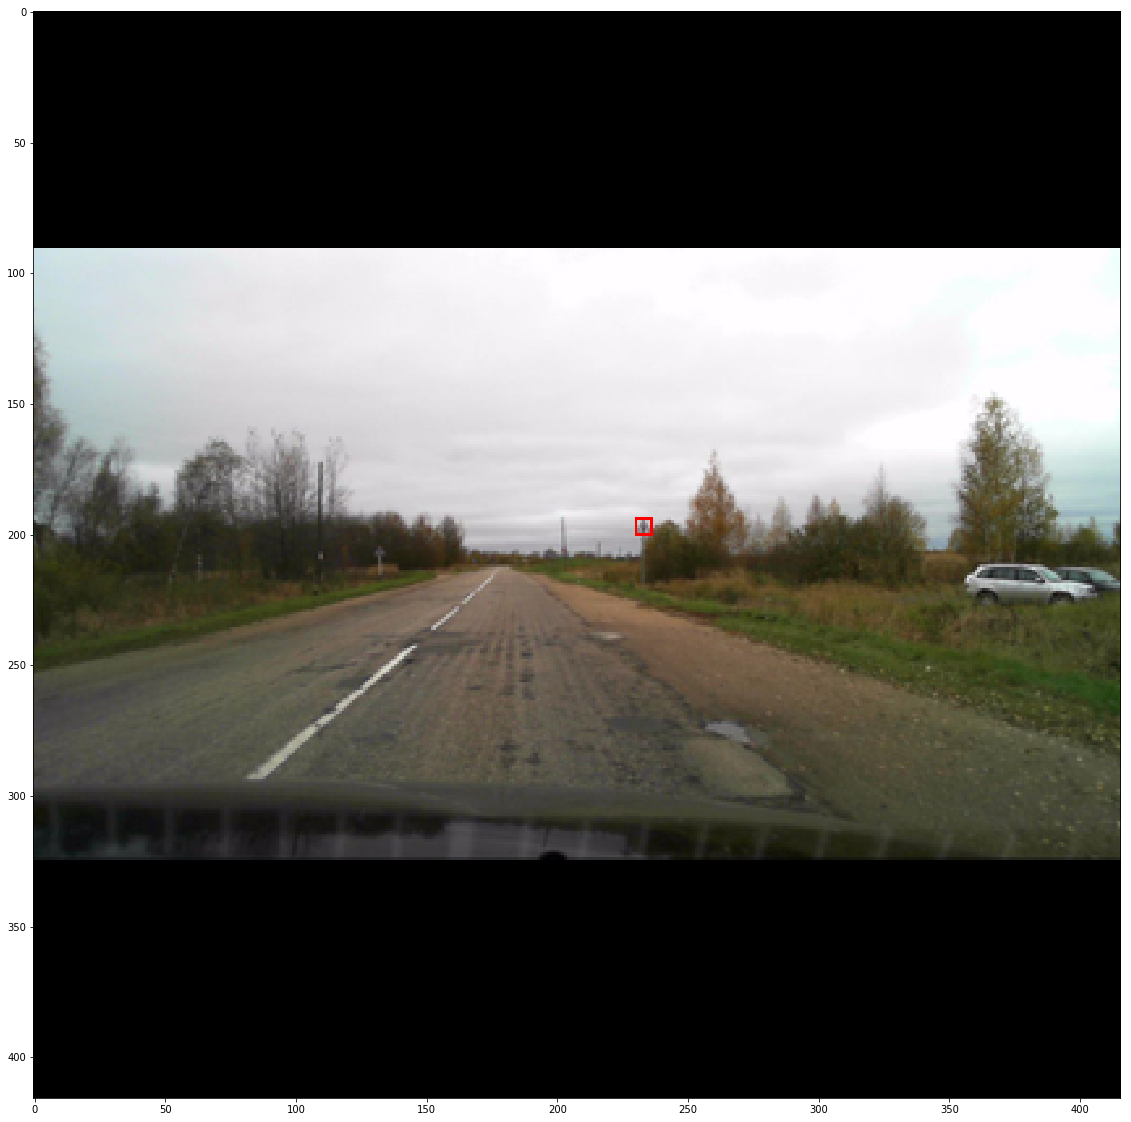

In [ ]:
from russian_signs.get_data import get_data

data = get_data()

images = data['images']
shuffle(images)

for image in images[:10]:
    print(image['filename'])
    img = Image.open(image['filename'])
    sq_img = get_squared_image(img, IMAGE_H)
    
    draw = ImageDraw.Draw(sq_img)
    for sign in image['signs']:
        draw.rectangle(((sign['xmin'] * IMAGE_H ,sign['ymin'] * IMAGE_H ), 
                        (sign['xmax'] * IMAGE_H ,sign['ymax'] * IMAGE_H )), outline="red")
        
    plt.figure(figsize=(20,20))
    plt.imshow(sq_img)
    plt.show()

In [ ]:
LABELS = data['LABELS']
CLASS = len(LABELS)

## network

In [ ]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3), name='input')

tr = True

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False, trainable=tr)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False, trainable=tr)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(lambda x: tf.space_to_depth(x, block_size=2))(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x) # x,y,h,w + confidence

model = Model(input_image, output)

## load weights

In [ ]:
weights = np.fromfile('yolo.weights', dtype='float32')

last_layer = 23

offset = 4 

for i in range(1, last_layer):
      
    conv_layer = model.get_layer('conv_' + str(i))

    if i < last_layer:
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weights[offset: offset+size]
        gamma = weights[offset+size: offset+size*2]
        mean  = weights[offset+size*2: offset+size*3]
        var   = weights[offset+size*3: offset+size*4]

        norm_layer.set_weights([gamma, beta, mean, var]) 

        offset += size*4

    if len(conv_layer.get_weights()) > 1: # use_bias = True
        size = np.prod(conv_layer.get_weights()[1].shape)
        bias = weights[offset: offset+size]
        offset += size
            
    size = np.prod(conv_layer.get_weights()[0].shape)
    kernel = weights[offset: offset+size]
    offset += size
    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
    kernel = kernel.transpose([2,3,1,0])
    
    if len(conv_layer.get_weights()) > 1:
        conv_layer.set_weights([kernel, bias])
    else:
        conv_layer.set_weights([kernel])
    
layer = model.get_layer('conv_' + str(last_layer)) # last conv layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

## utils

In [ ]:
def bbox_iou(box1, box2):
    x1_min  = box1.x - box1.w/2
    x1_max  = box1.x + box1.w/2
    y1_min  = box1.y - box1.h/2
    y1_max  = box1.y + box1.h/2

    x2_min  = box2.x - box2.w/2
    x2_max  = box2.x + box2.w/2
    y2_min  = box2.y - box2.h/2
    y2_max  = box2.y + box2.h/2

    intersect_w = interval_overlap([x1_min, x1_max], [x2_min, x2_max])
    intersect_h = interval_overlap([y1_min, y1_max], [y2_min, y2_max])

    intersect = intersect_w * intersect_h

    union = box1.w * box1.h + box2.w * box2.h - intersect

    return float(intersect) / union

def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3  

class BoundBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

        #self.c = c
        self.classes = classes

        #self.label = -1
        #self.score = -1

    def get_label(self):
        return np.argmax(self.classes)

    def get_score(self): 
        return self.classes[self.get_label()]

In [ ]:
images = data['images']

## generate anchor boxes (for resized images, 416*416)

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

boxes = []
for d in images:
    boxes += d['signs']

sizes = np.array([[(box['xmax'] - box['xmin']) * IMAGE_H, 
                   (box['ymax'] - box['ymin']) * IMAGE_H] for box in boxes])

kmeans = KMeans(n_clusters=5, random_state=0).fit(sizes)
ANCHORS = kmeans.cluster_centers_
print(ANCHORS)
print(Counter(kmeans.predict(sizes)))
# сравнение выбора kmeans и бокса с максимальным iou
anch_for_sizes = [
    np.argmax(
        np.array(
            [bbox_iou(
                BoundBox(0, 0, size[0], size[1]), 
                BoundBox(0, 0, anchor[0], anchor[1])) 
             for anchor in ANCHORS])) 
     for size in sizes]

print(Counter(anch_for_sizes))

ious = []
for n, size in enumerate(sizes):
    ious.append(bbox_iou(BoundBox(0, 0, size[0], size[1]), 
                         BoundBox(0, 0, ANCHORS[anch_for_sizes[n]][0], ANCHORS[anch_for_sizes[n]][1])))
  
print(np.mean(ious))

кажется, распределение хорошее

## batch generator

In [ ]:
from keras.utils import Sequence
#from imgaug import augmenters as iaa

class BatchGenerator(Sequence):
    
    def __init__(self, images):

        self.generator = None
        self.images = images
        self.anchors = [BoundBox(0, 0, anchor[0], anchor[1]) for anchor in ANCHORS]

        np.random.shuffle(self.images)
      
    def __len__(self):
        return int(np.ceil(float(len(self.images))/BATCH_SIZE)) 

    def __getitem__(self, idx):
        # границы батчей в массиве изображений
        l_bound = idx * BATCH_SIZE
        r_bound = (idx+1) * BATCH_SIZE

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - BATCH_SIZE

        # input images
        x_batch = np.zeros((r_bound - l_bound, 
                            IMAGE_H, IMAGE_W, 
                            3)) 

        y_batch = np.zeros((r_bound - l_bound, 
                            GRID_H, GRID_W, 
                            BOX, 4+1+CLASS))


        for num, train_instance in enumerate(self.images[l_bound:r_bound]):

            img, all_objs = self.aug_image(train_instance)
            
            for obj in all_objs:
                obj['xmin'] *= IMAGE_H
                obj['xmax'] *= IMAGE_H
                obj['ymin'] *= IMAGE_H
                obj['ymax'] *= IMAGE_H

            # construct output from object's x, y, w, h

            for obj in all_objs:
                center_x = (obj['xmin'] + obj['xmax']) / 2.
                center_y = (obj['ymin'] + obj['ymax']) / 2.
                
                # номера клеток
                grid_x = int(np.floor(center_x / (float(IMAGE_W) / GRID_W)))
                grid_y = int(np.floor(center_y / (float(IMAGE_H) / GRID_H)))

                #if grid_x < GRID_W and grid_y < GRID_H:

                obj_indx  = LABELS.index(obj['name'])

                # find the anchor that best predicts this box
                shifted_box = BoundBox(0, 0, obj['xmax'] - obj['xmin'], obj['ymax'] - obj['ymin'])
                best_anchor = np.argmax([bbox_iou(shifted_box, anchor) for anchor in self.anchors])
                
                y_batch[num, grid_y, grid_x, best_anchor, 0:4] = [
                    float(center_x * GRID_W) / float(IMAGE_W) - grid_x, # сдвиг в размерностях одной клетки
                    float(center_y * GRID_H) / float(IMAGE_H) - grid_y,
                    (obj['xmax'] - obj['xmin']) / float(ANCHORS[best_anchor][0]),
                    (obj['ymax'] - obj['ymin']) / float(ANCHORS[best_anchor][1])
                ]
                y_batch[num, grid_y, grid_x, best_anchor, 4  ] = 1.
                y_batch[num, grid_y, grid_x, best_anchor, 5+obj_indx] = 1

            x_batch[num] = img
      
        return x_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.images)

    def aug_image(self, train_instance):
        image_name = train_instance['filename']
        image = Image.open(image_name)

        if image is None: 
            print('Cannot find ', image_name)
        
        res_img = get_squared_image(image, IMAGE_H)
        all_objs = copy.deepcopy(train_instance['signs'])
        return res_img, all_objs

In [ ]:
import random

random.shuffle(images)

l = len(images)
train_imgs = images[:int(l*train_coef)]
test_imgs = images[int(-l*valid_coef):]

train_batch = BatchGenerator(train_imgs)
valid_batch = BatchGenerator(test_imgs)

## mAP

In [ ]:
#from tensorflow.contrib.framework import argsort
import keras.backend as K

iou_threshold = 0.6

def argsort(t):
  return tf.nn.top_k(t, tf.shape(t)[0])[1]


def bbox_iou_tf(box1, box2):
  x1_min  = box1[..., 0] - box1[..., 2] / tf.constant(2.0)
  x1_max  = box1[..., 0] + box1[..., 2] / tf.constant(2.0)
  y1_min  = box1[..., 1] - box1[..., 3] / tf.constant(2.0)
  y1_max  = box1[..., 1] + box1[..., 3] / tf.constant(2.0)  
  
  #print(box2)

  x2_min  = box2[..., 0] - box2[..., 2] / tf.constant(2.0)
  x2_max  = box2[..., 0] + box2[..., 2] / tf.constant(2.0)
  y = box2[..., 1]
  h = box2[..., 3]
  y2_min  = y - h / tf.constant(2.0)
  y2_max  = y + h / tf.constant(2.0)

  intersect_w = interval_overlap_tf(x1_min, x1_max, x2_min, x2_max)
  intersect_h = interval_overlap_tf(y1_min, y1_max, y2_min, y2_max)

  intersect = intersect_w * intersect_h

  union = box1[..., 2] * box1[..., 3] + box2[..., 2] * box2[..., 3] - intersect

  res = intersect / union
  
  #res = tf_print(res, [intersect], message="intersect \t")
  #res = tf_print(res, [union], message="union \t")
  #res = tf_print(res, [intersect / union], message="intersect / union \t")
  
  return res

def interval_overlap_tf(x1, x2, x3, x4):
  
  return \
    tf.where(
        tf.less(x3, x1),
        tf.where(
            tf.less(x4, x1),
            tf.zeros_like(x1),
            tf.minimum(x2,x4) - x1),
        tf.where(
            tf.less(x2, x3),
            tf.zeros_like(x1),
            x3 - tf.minimum(x2,x4)))

def process_netout(netout):
  
  result = [None for i in range(CLASS)]
  
  # make the boxes and the labels
  pred_boxes = tf.zeros([GRID_H, GRID_W, BOX, 7])

  boxes = np.full([GRID_H, GRID_W, BOX, 7], None)

  for row in range(GRID_H):
    for col in range(GRID_W):
      for b in range(BOX):
        # from 4th element onwards are confidence and classes
        classes = netout[row,col,b,5:]

        # first 4 elements are x, y, w, and h
        x = netout[row,col,b,0]
        y = netout[row,col,b,1]
        w = netout[row,col,b,2]
        h = netout[row,col,b,3]

        x = (col + x) / GRID_W # center position, unit: image width
        y = (row + y) / GRID_H # center position, unit: image height
        w = ANCHORS[b][0] * w / IMAGE_W # unit: image width
        h = ANCHORS[b][1] * h / IMAGE_H # unit: image height
        confidence = netout[row,col,b,4]

        #box = BoundBox(x, y, w, h, confidence, classes)

        boxes[row,col,b,0] = x
        boxes[row,col,b,1] = y
        boxes[row,col,b,2] = w
        boxes[row,col,b,3] = h
        boxes[row,col,b,4] = confidence
        boxes[row,col,b,5] = tf.to_float(tf.argmax(classes)) # label
        boxes[row,col,b,6] = classes[tf.argmax(classes)] # score_for_label


  # remove the boxes which are less likely than a obj_threshold

  pred_boxes = tf.stack(boxes.reshape([GRID_H*GRID_W*BOX, 7]).tolist())
  pred_boxes = tf.boolean_mask(pred_boxes, tf.greater(pred_boxes[:,6], tf.constant(OBJ_THRESHOLD)))

  score = pred_boxes[:,6]
  pred_labels = pred_boxes[:,5]


  #if len(pred_boxes) > 0:
  #  pred_boxes = np.array([[box.xmin, box.ymin, box.xmax, box.ymax, box.get_score()] for box in pred_boxes]) 
  #else:
  #  pred_boxes = np.array([[]])  

  # sort the boxes and the labels according to scores
  score_sort = argsort(-score)
  #pred_labels = pred_labels[score_sort, :]
  #pred_boxes  = pred_boxes[score_sort, :]

  # copy detections to all_detections
  for label in range(CLASS):
    result[label] = tf.boolean_mask(pred_boxes, 
                                    tf.equal(pred_labels, tf.constant(float(label))))
    
  return result

def IOU(y_true, y_pred):
  
  all_detections  = [process_netout(y_pred[j]) for j in range(BATCH_SIZE)]
  # batch x class x boxes x 7
  all_annotations = [process_netout(y_true[j]) for j in range(BATCH_SIZE)]
  
  ious_ar = []
  
  for label in range(CLASS):    
    for i in range(BATCH_SIZE):
      
      detections = all_detections[i][label] # tensor num_preds x 7
      annotations = all_annotations[i][label]      
      
      ious = tf.reduce_max(tf.map_fn(lambda annotation: 
                                     bbox_iou_tf(detections,
                                                 tf.tile(annotation, [tf.shape(detections)[0]])),
                                     annotations),
                         axis=0) # len(detections)
      
      ious_ar.append(ious)
     
  ious_ar = tf.concat(ious_ar,0)
  
  res = tf.reduce_mean(ious_ar)
  
  #res = tf_print(res, [average_precisions], message="average_precisions \t")
                              
  return res
  

def mAP(y_true, y_pred):
  
      
  all_detections  = [process_netout(y_pred[j]) for j in range(BATCH_SIZE)]
  # batch x class x boxes x 7
  all_annotations = [process_netout(y_true[j]) for j in range(BATCH_SIZE)]
  
  # compute mAP by comparing all detections and all annotations
  average_precisions = []

  for label in range(CLASS):
    
    num_annotations = tf.constant(0)
    
    scores = []
    tps = []
    
    for i in range(BATCH_SIZE):
      
      detections = all_detections[i][label] # tensor num_preds x 7
      annotations = all_annotations[i][label]
      num_annotations  += tf.shape(annotations)[0]
      #detected_annotations = []
      
      scores.append(detections[:, 6]) # append tensor num_detections x 1
      
      tp = tf.cond(tf.equal(tf.shape(annotations)[0], tf.constant(0)),
                   lambda: tf.zeros(tf.shape(detections)[0]),
                   lambda: tf.cond(tf.equal(tf.shape(detections)[0], tf.constant(0)),
                                   lambda: -tf.ones([tf.shape(detections)[0]]),
                                   lambda: \
                                      tf.where(
                                       tf.greater_equal(
                                         tf.reduce_max(
                                            tf.map_fn(
                                              lambda annotation: 
                                                bbox_iou_tf(detections, 
                                                            tf.tile(annotation, [tf.shape(detections)[0]])),
                                              annotations),
                                            axis=0),
                                         tf.tile([tf.constant(iou_threshold, dtype=tf.float32)], [tf.shape(detections)[0]])),
                                       tf.ones([tf.shape(detections)[0]]),
                                       tf.zeros([tf.shape(detections)[0]]))))
      
      tps.append(tp)
     
    scores = tf.concat(scores,0)
    tps = tf.concat(tps, 0)
    
    indices = argsort(-scores)
    #tps = tf_print(tps, [tps], message="tps \t")
    tps = tf.gather(tps, indices)
    tps = tf.cumsum(tps)
    
    recall = tps / tf.to_float(num_annotations)
    precision = tps / tf.to_float(tf.shape(tps)[0])
    
    #precision = tf_print(precision, [precision], message="precision \t")
    
    average_precisions.append(tf.cond(tf.equal(num_annotations, 0),
                              lambda: tf.constant(0.0),
                              lambda: tf.cond(tf.equal(tf.shape(precision)[0], 0),
                                      lambda: tf.constant(0.0),
                                      lambda: tf.reduce_mean(tf.gather(precision, argsort(recall))[:10]))))
                              
  
  average_precisions = tf.stack(average_precisions)
  res = tf.reduce_mean(average_precisions)
  
  #res = tf_print(res, [average_precisions], message="average_precisions \t")
                              
  return res

## loss

In [ ]:
def tf_print(op, tensors, message=None):
    def print_message(x):
        sys.stdout.write("\n" + message + " %s\n" % x)
        return x

    prints = [tf.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    with tf.control_dependencies(prints):
        op = tf.identity(op)
    return op

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [ ]:
def custom_loss(y_true, y_pred):
    xy_pred = y_pred[..., :2]
    wh_pred = y_pred[..., 2:4]
    conf_pred = y_pred[..., 4]
    class_pred = y_pred[..., 5:]

    xy_true = y_true[..., :2]
    wh_true = y_true[..., 2:4]
    conf_true = y_true[..., 4]
    class_true = y_true[..., 5:]

    mask_ij_obj = conf_true
    mask_ij_noobj = tf.ones(tf.shape(conf_true)) - conf_true

    loss_xy    = tf.reduce_sum(mask_ij_obj * tf.reduce_sum(tf.square(xy_pred - xy_true), -1))
    loss_wh    = tf.reduce_sum(mask_ij_obj * tf.reduce_sum(tf.square(wh_pred - wh_true), -1))
    loss_conf_f = tf.reduce_sum(mask_ij_obj * tf.square(conf_pred - conf_true))
    loss_conf_s = tf.reduce_sum(mask_ij_noobj * tf.square(conf_pred - conf_true))
    loss_class = tf.reduce_sum(mask_ij_obj * tf.reduce_sum(tf.square(class_pred - class_true), -1))

    loss = 5.0 * loss_xy + 5.0 * loss_wh + loss_conf_f + 0.5 * loss_conf_s + loss_class

    #loss = tf_print(loss, [loss_xy], message='loss xy \t')
    #loss = tf_print(loss, [loss_wh], message='loss wh \t')
    #loss = tf_print(loss, [loss_conf], message='loss conf \t')
    #loss = tf_print(loss, [loss_class], message='loss class \t')
    
    tf.summary.scalar('loss', loss)

    return loss

## Train

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', 
#                           min_delta=0.000001, 
#                           patience=3, 
#                           mode='min', 
#                           verbose=1)

checkpoint = ModelCheckpoint('weights_russian_{epoch:02d}_{val_loss:.2f}.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             #save_best_only=True, 
                             mode='min', 
                             period=1)


class TB(TensorBoard):
    def __init__(self, log_every=1, **kwargs):
        super().__init__(**kwargs)
        self.log_every = log_every
        self.counter = 0
    
    def on_batch_end(self, batch, logs=None):
        self.counter+=1
        if self.counter%self.log_every==0:
            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, self.counter)
            self.writer.flush()
        
        super().on_batch_end(batch, logs)

tb_counter  = len([log for log in os.listdir(os.path.expanduser('logs/'))]) + 1
tensorboard = TB(log_dir='logs/run_'+str(tb_counter), histogram_freq=0, write_graph=True)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

import keras

class SaveWeightsCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        os.system("telegram-send \"!!!!!!!!!\nepoch "+str(epoch)+" end, val_loss \n" + str(logs["val_loss"])+"\"")
        return
  
    def on_batch_end(self, batch, logs={}):
        if batch % 10 == 0:
            os.system("telegram-send \"batch "+str(logs["batch"])+" end, loss \n"+str(logs["loss"])+"\"")
        return
  
save_weights = SaveWeightsCallback()

In [ ]:
start_time = datetime.now()
model.compile(loss=custom_loss, optimizer=optimizer)
print ("compile done {}".format(datetime.now() - start_time))
model.load_weights("weights_swedish.h5")
model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint, save_weights, tensorboard])

3919/3919 [==============================] - 7759s 2s/step - loss: 11.9599 - val_loss: 10.9997

Epoch 00001: saving model to weights_russian_01_11.00.h5
Epoch 2/100
2239/3919 [================>.............] - ETA: 48:58 - loss: 8.7873

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3919/3919 [==============================] - 7663s 2s/step - loss: 8.8546 - val_loss: 10.5039

Epoch 00002: saving model to weights_russian_02_10.50.h5
Epoch 3/100
   1/3919 [..............................] - ETA: 1:49:13 - loss: 7.5057

/jet/var/python/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (8.735031). Check your callbacks.
  % delta_t_median)


   2/3919 [..............................] - ETA: 6:36:12 - loss: 7.4199

/jet/var/python/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (4.368319). Check your callbacks.
  % delta_t_median)


3919/3919 [==============================] - 7645s 2s/step - loss: 7.3850 - val_loss: 10.3297

Epoch 00003: saving model to weights_russian_03_10.33.h5
Epoch 4/100
2144/3919 [===============>..............] - ETA: 51:40 - loss: 6.2518

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3919/3919 [==============================] - 7811s 2s/step - loss: 5.6065 - val_loss: 10.2056

Epoch 00005: saving model to weights_russian_05_10.21.h5
Epoch 6/100
 876/3919 [=====>........................] - ETA: 1:27:13 - loss: 4.8893

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3556/3919 [==========================>...] - ETA: 10:26 - loss: 4.4957

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1981/3919 [==============>...............] - ETA: 56:08 - loss: 3.9938

## Process results

In [ ]:
def decode_netout(netout, obj_threshold, anchors, nb_class):
  grid_h, grid_w, nb_box = netout.shape[:3]

  boxes = []

  # netout[..., 5:] *= netout[..., 5:] > obj_threshold

  for row in range(grid_h):
    for col in range(grid_w):
      for b in range(nb_box):
        # from 4th element onwards are confidence and classes
        classes = netout[row,col,b,5:]

        if classes.any():
          # first 4 elements are x, y, w, and h
          x, y, w, h = netout[row,col,b,:4]

          x = (col + x) / grid_w # center position, unit: image width
          y = (row + y) / grid_h # center position, unit: image height
          # w = acnhors[b][0] * w / image_w
          w = anchors[b][0] * w / IMAGE_W # unit: image width
          h = anchors[b][1] * h / IMAGE_H # unit: image height
          confidence = netout[row,col,b,4]

          box = BoundBox(x, y, w, h, confidence, classes)

          boxes.append(box)

  # remove the boxes which are less likely than a obj_threshold
  boxes = [box for box in boxes if box.get_score() > obj_threshold]

  return boxes
  
def draw_boxes(image, boxes, labels):
  
  for num, box in enumerate(boxes):
    center_x = int(box.x * image.size[1])
    center_y = int(box.y * image.size[0])
    xmin  = int((box.x - box.w/2) * image.size[1])
    xmax  = int((box.x + box.w/2) * image.size[1])
    ymin  = int((box.y - box.h/2) * image.size[0])
    ymax  = int((box.y + box.h/2) * image.size[0])
    
    draw = ImageDraw.Draw(image)
    draw.rectangle(((xmin,ymin), (xmax,ymax)), outline="red")
    draw.text((xmin, ymin - 13), str(num), fill="red")
    
    print(num, labels[box.get_label()], str(box.get_score()))

  return image

In [ ]:
def print_img(img, preds):

  plt.figure(figsize=(15,15))  

  boxes = decode_netout(preds, 
                        obj_threshold=0.9,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
  
  image = draw_boxes(img, boxes, labels=LABELS)
  plt.imshow(image)
  plt.show()

In [ ]:
def print_valid(file, d):
    image = Image.open(file)
    draw = ImageDraw.Draw(image)
    plt.figure(figsize=(15,15))  
    
    inc = 0
    
    for sign in d['signs']:
        print((sign['xmin'], sign['ymin']), (sign['xmax'], sign['ymax']))
        draw.rectangle(((sign['xmin'], sign['ymin']), (sign['xmax'], sign['ymax'])), outline="red")
        print (inc, sign['name'])
        draw.text((sign['xmin'], sign['ymin'] - 13), str(inc), fill="red")
        inc += 1
    plt.imshow(image)
    plt.show()

In [ ]:
from matplotlib.pyplot import imshow

#folder = "train"

#model.load_weights("weights.h5")

#dicts = parse_annotation('road_signs/annotations.txt', 'road_signs/images/'+folder, labels=LABELS)

for image in np.random.choice(images, 10):
    input_image_or = Image.open(image['filename'])
    input_image = input_image_or.resize((416, 416))
    netout = model.predict(np.expand_dims(input_image, 0))
    print_img(input_image, netout[0])
    print_valid("road_signs/images/"+folder+"/"+filename, 
                list(filter(lambda d: d['filename'] == "road_signs/images/"+folder+"/"+filename, dicts))[0])

In [ ]:
list(filter(lambda d: d['filename'] == "road_signs/images/train/1277381655Image000002.jpg", dicts))[0]

In [ ]:
os.listdir("road_signs/images/valid")

In [ ]:
from random import shuffle

l = os.listdir("road_signs/images")
shuffle(l)
for f in l[:1500]:
    if not os.path.isdir("road_signs/images/"+f):
        os.rename("road_signs/images/"+f,"road_signs/images/train/"+f)
for f in l[1500:]:
    if not os.path.isdir("road_signs/images/"+f):
        os.rename("road_signs/images/"+f,"road_signs/images/valid/"+f)

In [ ]:
from random import shuffle


l = os.listdir("road_signs/images/train")
shuffle(l)
print(len(l))

for f in l[1500:]:
    if not os.path.isdir("road_signs/images/train/"+f):
        os.rename("road_signs/images/train/"+f,"road_signs/images/valid/"+f)

In [ ]:
len(os.listdir("road_signs/images/train"))

In [ ]:
len(os.listdir("road_signs/images/valid"))